In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive

Read and setup data

In [ ]:
data = pd.read_excel('/content/doctors.xlsx')

In [ ]:
#Encode labels to numeric id
data['category_id'] = data['Label1'].factorize()[0]
categoryDf = data[['Label1', 'category_id']].sort_values('category_id')
category_to_id = dict(categoryDf.values)
id_to_category = dict(categoryDf[['category_id', 'Label1']].values)

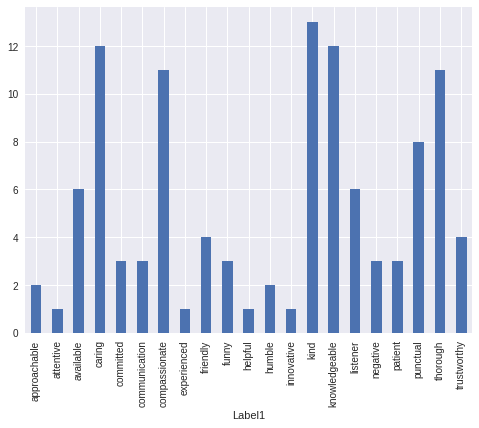

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('Label1').Name.count().plot.bar(ylim=0)
plt.show()

In [ ]:
#Determine term frequency, learn vocab, return document term matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data.Review).toarray()
labels = data.category_id
features.shape

(110, 117)

In [ ]:
#Preform basic feature selection - most correlated words for each descriptor
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Label1, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Label1))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'approachable':
  . Most correlated unigrams:
. amin
. knowledge
  . Most correlated bigrams:
. best doctor
. dr amin
# 'attentive':
  . Most correlated unigrams:
. covid
. wait
  . Most correlated bigrams:
. family doctor
. best doctor
# 'available':
  . Most correlated unigrams:
. open
. weinstein
  . Most correlated bigrams:
. best doctor
. dr weinstein
# 'caring':
  . Most correlated unigrams:
. caring
. new
  . Most correlated bigrams:
. dr amin
. dr eisen
# 'committed':
  . Most correlated unigrams:
. understanding
. cares
  . Most correlated bigrams:
. dr eisen
. years ago
# 'communication':
  . Most correlated unigrams:
. people
. extremely
  . Most correlated bigrams:
. dr amin
. bedside manner
# 'compassionate':
  . Most correlated unigrams:
. rossiter
. compassionate
  . Most correlated bigrams:
. bedside manner
. dr eisen
# 'experienced':
  . Most correlated unigrams:
. experience
. amin
  . Most correlated bigrams:
. family doctor
. dr amin
# 'friendly':
  . Most correla

In [ ]:
#Setup Data
x_data = data.drop(columns=['Label1', 'Label2'])
y_data = data[['Label1']]

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
#Setup Testing Sets

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

print(x_train.head())
print('x training shape =', x_train.shape)
print('y training shape =', y_train.shape)
print('x testing shape =', x_test.shape)
print('y testing shape =', y_test.shape)

                   Name  ... category_id
108            A Joneja  ...           2
80           Alex Klein  ...          19
88           Alex Klein  ...           2
79      James Rodgerson  ...          19
31   Leslie Housefather  ...           2

[5 rows x 8 columns]
x training shape = (77, 8)
y training shape = (77, 1)
x testing shape = (33, 8)
y testing shape = (33, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


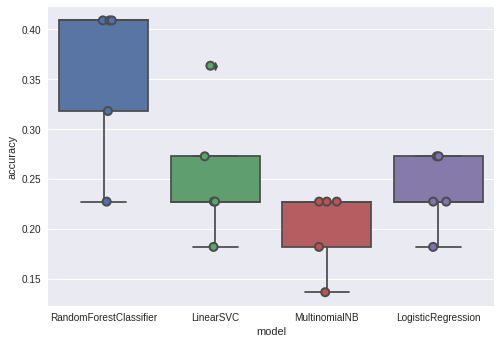

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model', y='accuracy', data=cv_df)
sns.stripplot(x='model', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(data['Review'], data['Label1'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = RandomForestClassifier().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform(["patient and humble, great communicator this guy was super funny and I loved being in his office"])))

['kind']


In [ ]:
cv_df.groupby('model').accuracy.mean()

model
LinearSVC                 0.254545
LogisticRegression        0.236364
MultinomialNB             0.200000
RandomForestClassifier    0.354545
Name: accuracy, dtype: float64

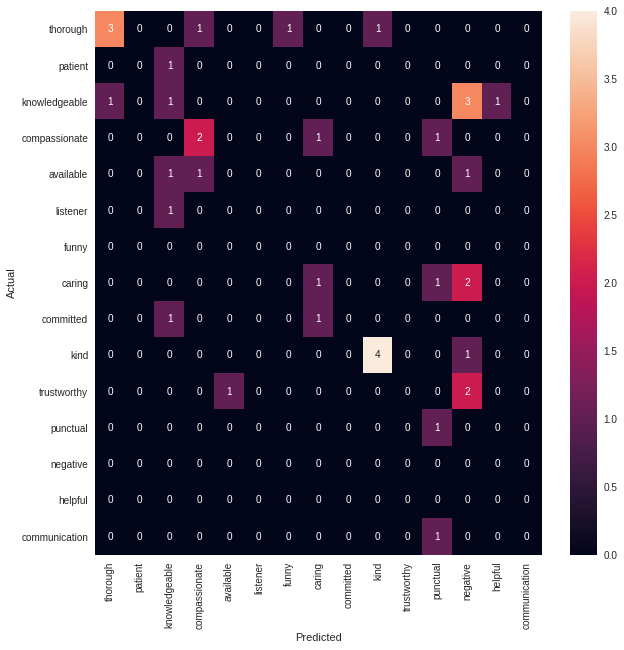

In [ ]:
model = RandomForestClassifier()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
tn = ['thorough', 'patient', 'knowledgeable', 'compassionate', 'available', 'listener', 
                'funny', 'caring', 'committed', 'kind', 'trustworthy', 'punctual', 
                'negative', 'helpful', 'communication']
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=tn, yticklabels=tn)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Find other metrics *

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

NameError: ignored

In [ ]:
from sklearn import metrics
target_names = ['thorough', 'patient', 'knowledgeable', 'compassionate', 'available', 'listener', 
                'funny', 'caring', 'humble', 'committed', 'kind', 'trustworthy', 'punctual', 'attentive',
                'negative', 'helpful', 'approachable', 'communication', 'experienced', 'friendly',
                'patient', 'innovative']
tn = ['thorough', 'patient', 'knowledgeable', 'compassionate', 'available', 'listener', 
                'funny', 'caring', 'committed', 'kind', 'trustworthy', 'punctual', 
                'negative', 'helpful', 'communication']  
print(metrics.classification_report(y_test, y_pred, target_names=tn))
#humble#8 attentive#13 helpful#15 approachable#16 #18experienced #19friendly #21innovative

ValueError: ignored

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

In [ ]:
#Setup Preprocessing 
numeric_features = ['Staff', 'Punctuality', 'Helpfulness', 'Knowledge', 'Rating']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

categorical_features = ['Name', 'Review']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
#Setup model
regr = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', KNeighborsRegressor())])

x_train = x_train[[*numeric_features, *categorical_features]]
x_test = x_test[[*numeric_features, *categorical_features]]

param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'regressor__n_neighbors': [10]
}

grid_search = GridSearchCV(
    regr, param_grid, cv=5, verbose=3, n_jobs=2
)

In [ ]:
model = grid_search.fit(x_train, y_train)

ValueError: ignored

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
mpreds = model.predict(x_test)
sc = r2_score(y_test['usd_pledged_real'],mpreds)
print(sc)